In [1]:
import os
from os import path
from datetime import datetime, timedelta, date
import pytz

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import networkx as nx
#plt.switch_backend("cairo")

In [2]:
title = "WKU"
data_folder = "./data"
output_folder = "./output"
sim_id = 165
sim_tz = "Asia/Shanghai"
time0 = 'Nov 20 2023 9:00AM'
time1 = 'Dec 4 2023 12:00PM'
time_step_min = 30

use_new_id_schema = True   

# Print warning messages to the console when parsing data
print_data_warnings = False

# Default contact time for transmissions that are missing an associated contact event
def_contact_time = 10

# Time delta for plots in seconds
time_delta_sec = 60 * time_step_min

if not path.exists(output_folder):
    os.makedirs(output_folder)

# https://howchoo.com/g/ywi5m2vkodk/working-with-datetime-objects-and-timezones-in-python
# https://itnext.io/working-with-timezone-and-python-using-pytz-library-4931e61e5152
timezone = pytz.timezone(sim_tz)

if time0 and time1:
    obs_date0 = timezone.localize(datetime.strptime(time0, '%b %d %Y %I:%M%p'))
    obs_date1 = timezone.localize(datetime.strptime(time1, '%b %d %Y %I:%M%p'))
else:
    obs_date0 = None
    obs_date1 = None

In [3]:
# Data parsing functions

# It calculates the weights in minutes
def get_contact_list(events, infections):
    mili_to_seconds = 60 * 1000
    
    contacts = events[events["type"] == "contact"]

    node0 = contacts.user_id.values
    node1 = contacts.peer_id.values
    length = contacts.contact_length.values

    clist = {}
    for id0, id1, l01 in zip(node0, node1, length):
        n0 = user_index[id0]
        n1 = -1
        if use_new_id_schema:
            if id1 in user_index:
                n1 = user_index[id1]
            elif print_data_warnings:
                print("Cannot find peer", id1)
        else:
            if id1 in p2pToId:
                n1 = user_index[p2pToId[id1]]
            elif print_data_warnings:
                print("Cannot find peer", id1)
    
        if -1 < n1:
            if n0 < n1:
                p01 = (n0, n1)
            else:
                p01 = (n1, n0)
            if p01 in clist:
                c = clist[p01]
            else: 
                c = 0
            
            clist[p01] = c + round(l01 / mili_to_seconds)

    for p in clist:
        clist[p] /= 2
    
    # Adding contacts from transmissions if they are not registered as contacts already
    for (n0, n1) in infections:
        if n0 < n1:
            p01 = (n0, n1)
        else:
            p01 = (n1, n0)
        if not p01 in clist:
            clist[p01] = def_contact_time
            if print_data_warnings: print("Cannot find contact between", n0, "and", n1)            

    return clist

def get_infection_list(events):
    infections = events[(events["type"] == "infection")]
    
    ilist = []
    itimes = {}
    infected = infections.user_id.values
    peers = infections.inf.values
    timestamp = infections.time.values
    for id1, peer0, ts in zip(infected, peers, timestamp):
        n1 = user_index[id1]
            
        if "PEER" in peer0:
            if use_new_id_schema:
                # New schema
                id0 = int(peer0[peer0.index("[") + 1:peer0.index(":")])
                if id0 in user_index:
                    n0 = user_index[id0]                    
                    add_infection = True
                    for e in ilist:
                        if e[1] == n1:
                            pid0 = index_user[e[0]]
                            ts0 = itimes[(pid0, id1)]
                            if abs(ts - ts0) <= time_delta_sec:
                                add_infection = False
                                if print_data_warnings:
                                    if pid0 == id0:
                                        print("Duplicated infection:", id1, "was already infected by", id0, "in the last", time_step_min, "minutes")
                                    else:
                                        print("Multiple infection:", id1, "is being infected by", id0, "but was already infected by", pid0, "in the last", time_step_min, "minutes")
                                break    

                    if add_infection: 
                        ilist += [(n0, n1)]
                        itimes[(id0, id1)] = ts
                elif print_data_warnings:
                    print("Cannot find peer", id0)                    
            else:    
                # Old schema (sims before 2022): p2p id is in the infection column
                p2p0 = peer0[peer0.index("[") + 1:peer0.index(":")]
                if p2p0 in p2pToId:
                    id0 = p2pToId[p2p0]
                    if id0 in user_index:
                        n0 = user_index[id0]
                        if not (n0, n1) in ilist:                        
                            ilist += [(n0, n1)]
                        elif print_data_warnings:
                            print("Duplicated infection", id0, id1)  
                elif print_data_warnings:
                    print("Cannot find peer", p2p0)                        
            
    return ilist 

def get_node_status(events, status0 = None):    
    if status0 == None:
         status = [0] * len(users)
    else:            
        status = status0

    inf = events[events["type"] == "infection"]
    infMap = pd.Series(inf.inf.values, index=inf.user_id).to_dict()
    for kid in infMap:
        src = infMap[kid]
        idx = user_index[kid]
        if "CASE0" in src:
            status[idx] = 1
        if "PEER" in src:
            status[idx] = 2
            id0 = int(src[5:].split(":")[0])
            idx0 = user_index[id0]       
            if status[idx0] == 0:
                status[idx0] = 1
                if print_data_warnings:
                    print("Infecting peer did not have correct status", idx0)

    out = events[events["type"] == "outcome"]
    outMap = pd.Series(out.out.values, index=out.user_id).to_dict()
    for kid in outMap:
        out = outMap[kid]
        idx = user_index[kid]
        if out == "DEAD":
            status[idx] = 3
        if out == "RECOVERED":
            status[idx] = 4
        if out == "VACCINATED":
            status[idx] = 5
    
    return status

def get_score_events(events):
    scores_events = events[(events["type"] == "score")]
    return scores_events

def get_behavior_counts(events):
    nq = len(events[(events["inf"] == "quarantine")])
    nnq = len(events[(events["inf"] == "noQuarantine")])
    return {"quarantine_choice_yes":nq, "quarantine_choice_no":nnq}

In [4]:
# Some utilities

# https://stackoverflow.com/a/48938464
def hour_rounder(t):
    # Rounds to nearest hour by adding a timedelta hour if minute >= 30
    return (t.replace(second=0, microsecond=0, minute=0, hour=t.hour)
               +timedelta(hours=t.minute//30))

In [5]:
# Load participants and histories

all_users = pd.read_csv(path.join(data_folder, "participants.csv"), low_memory=False) 
all_events = pd.read_csv(path.join(data_folder, "histories.csv"), low_memory=False)

users = all_users[all_users["sim_id"] == sim_id]

events = all_events[all_events["sim_id"] == sim_id]
events.fillna({'contact_length':0, 'peer_id':-1}, inplace=True)
events["event_start"] = events["time"] - events["contact_length"]/1000
events["event_start"] = events["event_start"].astype(int)

p2pToSim = pd.Series(users.sim_id.values, index=users.p2p_id).to_dict()
p2pToId = pd.Series(users.id.values, index=users.p2p_id).to_dict()
idTop2p = pd.Series(users.p2p_id.values, index=users.id).to_dict()
        
user_index = {}
index_user = {}
idx = 0
for kid in idTop2p:
    user_index[kid] = idx
    index_user[idx] = kid
    idx += 1

# Round min and max times to the hour
min_time = min(events['time'])
max_time = max(events['time'])
first_date = hour_rounder(datetime.fromtimestamp(min_time, tz=timezone))
last_date = hour_rounder(datetime.fromtimestamp(max_time, tz=timezone))
min_time = datetime.timestamp(first_date)
max_time = datetime.timestamp(last_date)

print("First event:", first_date)
print("Last event :", last_date)

if time0 and time1:
    print("Start time:", datetime.strptime(time0, '%b %d %Y %I:%M%p'))
    print("End time:", datetime.strptime(time1, '%b %d %Y %I:%M%p'))

print(first_date.tzinfo)

# These should return the same value
print(len(users))
print(len(idTop2p))    
print(len(p2pToId))
print(len(user_index))

First event: 2023-11-19 15:00:00+08:00
Last event : 2023-12-05 16:00:00+08:00
Start time: 2023-11-20 09:00:00
End time: 2023-12-04 12:00:00
Asia/Shanghai
794
794
794
794


In [6]:
status = get_node_status(events)
infections = get_infection_list(events)
contacts = get_contact_list(events, infections)

In [398]:
# Create the network, skipping edges between nodes that spend less than min_contact_time
# in contact during the entire sim
def create_network(contacts, status, minw=0):
    nodes = [i for i in range(0, len(user_index))]
    edges = []
    weights = []    
    if 0 < len(contacts):
        for p in contacts:
            n0 = p[0]
            n1 = p[1]
            w = contacts[p]            
            if minw < w:
                edges += [(n0, n1)]
                weights += [w]
    
    g = nx.Graph()
    g.add_nodes_from(nodes)
    g.add_weighted_edges_from([(edges[i][0], edges[i][1], weights[i]) for i in range(len(edges))])
    
    return g

def remove_nodes_with_less_edges(G, k):
    nodes_to_remove = [node for node, degree in dict(G.degree()).items() if degree < k]
    G.remove_nodes_from(nodes_to_remove)


min_total_contact_time = 5  # at least this total time (in minutes) over the two weeks to be defined as in contact
min_total_contact_count = 1 # nodes must have at least this number of edges with other nodes to be kept

G = create_network(contacts, status, min_total_contact_time)

print(len(G.nodes()), len(G.edges()))

remove_nodes_with_less_edges(G, min_total_contact_count)
print(len(G.nodes()), len(G.edges()))

G.remove_nodes_from(list(nx.isolates(G)))
print(len(G.nodes()), len(G.edges()))

794 1802
474 1802
474 1802


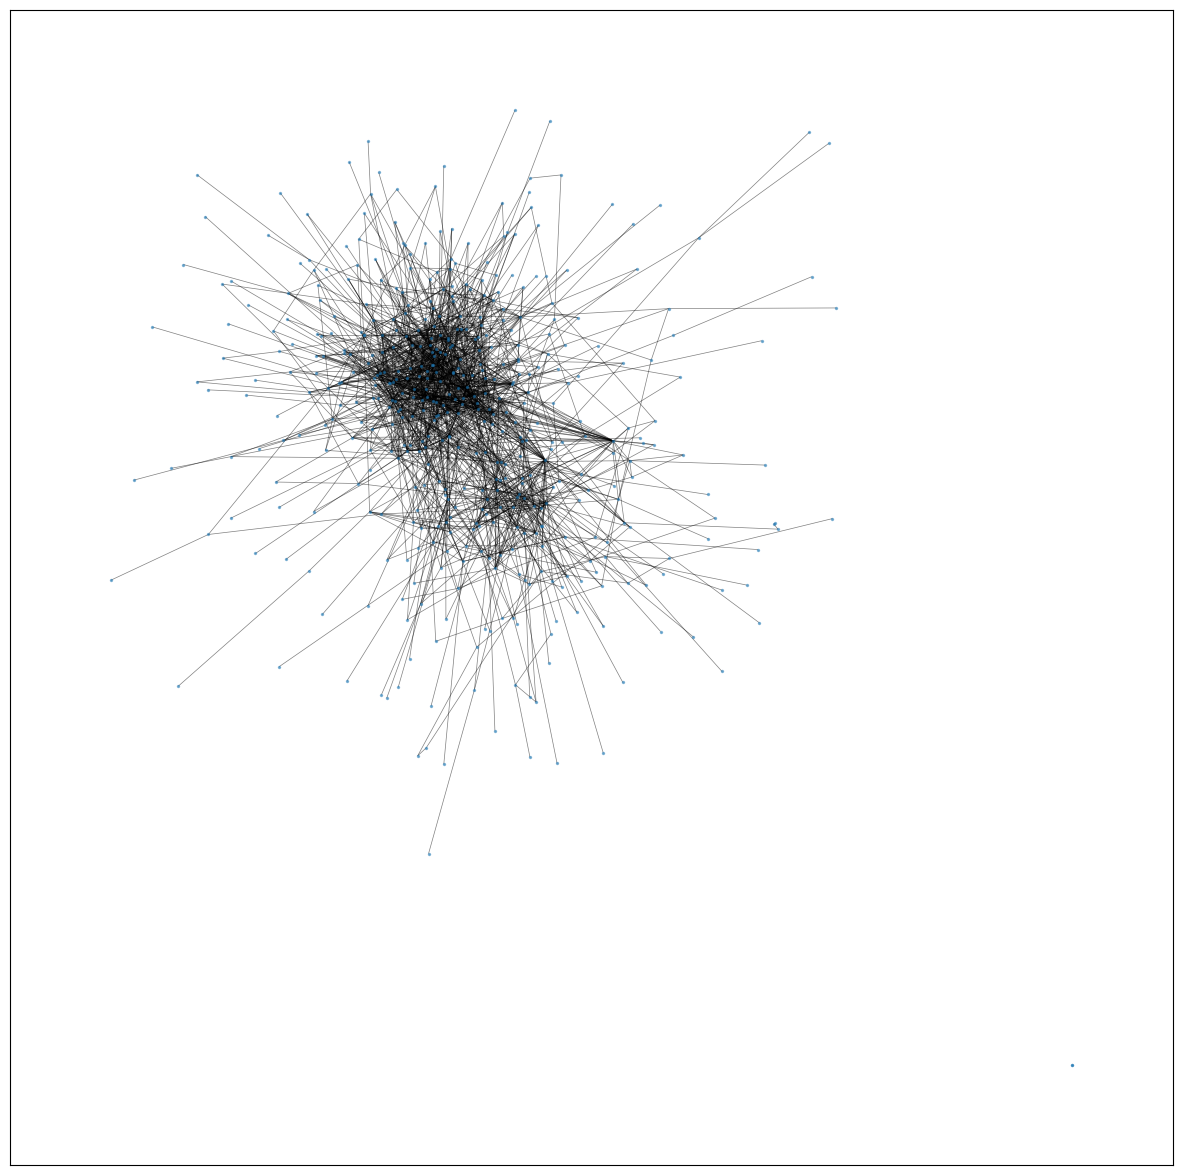

In [399]:
# Plot a basic spring layour of the entire network
pos = nx.spring_layout(G)
plt.figure(figsize=(15, 15))
nx.draw_networkx(G, pos, with_labels=False, node_size=2, width=0.5, alpha=0.5)
plt.show()

In [400]:
# If your Graph has more than one component, this will return False:
print("Network is connected", nx.is_connected(G))

components = nx.connected_components(G)

subgraphs = [G.subgraph(c) for c in components]
for sg in subgraphs:
    print(len(sg.nodes()), len(sg.edges()))

# Calculate the largest connected component subgraph: largest_ccs
G = sorted(subgraphs, key=lambda x: len(x))[-1]

Network is connected False
472 1801
2 1


In [401]:
print("Network density:", nx.density(G))
print("Network diameter:", nx.diameter(G))

Network density: 0.016202454208499768
Network diameter: 9


In [402]:
pos = nx.spring_layout(G)

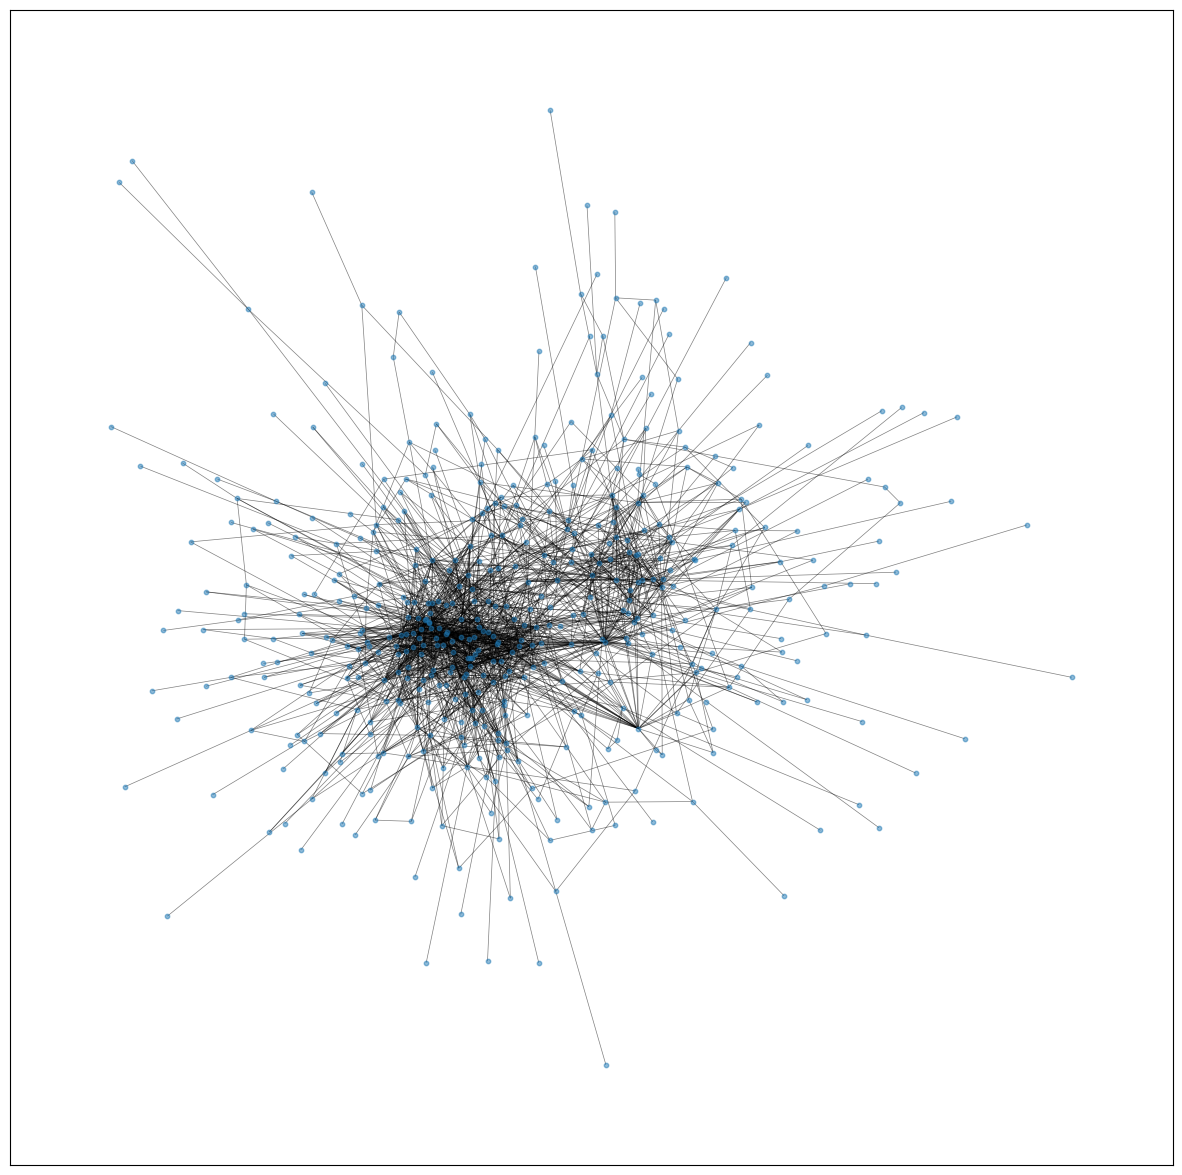

In [403]:
plt.figure(figsize=(15, 15))
nx.draw_networkx(G, pos, with_labels=False, node_size=10, width=0.5, alpha=0.5)
plt.show()

From https://programminghistorian.org/en/lessons/exploring-and-analyzing-network-data-with-python

The final structural calculation you will make on this network concerns the concept of triadic closure. Triadic closure supposes that if two people know the same person, they are likely to know each other. If Fox knows both Fell and Whitehead, then Fell and Whitehead may very well know each other, completing a triangle in the visualization of three edges connecting Fox, Fell, and Whitehead. The number of these enclosed triangles in the network can be used to find clusters and communities of individuals that all know each other fairly well.

One way of measuring triadic closure is called clustering coefficient because of this clustering tendency, but the structural network measure you will learn is known as transitivity.10 Transitivity is the ratio of all triangles over all possible triangles. A possible triangle exists when one person (Fox) knows two people (Fell and Whitehead). So transitivity, like density, expresses how interconnected a graph is in terms of a ratio of actual over possible connections. Remember, measurements like transitivity and density concern likelihoods rather than certainties. All the outputs of your Python script must be interpreted, like any other object of research. Transitivity allows you a way of thinking about all the relationships in your graph that may exist but currently do not.

You can calculate transitivity in one line, the same way you calculated density:
    

In [404]:
triadic_closure = nx.transitivity(G)
print("Triadic closure:", triadic_closure)

Triadic closure: 0.19165594165594166


## Community detection

11


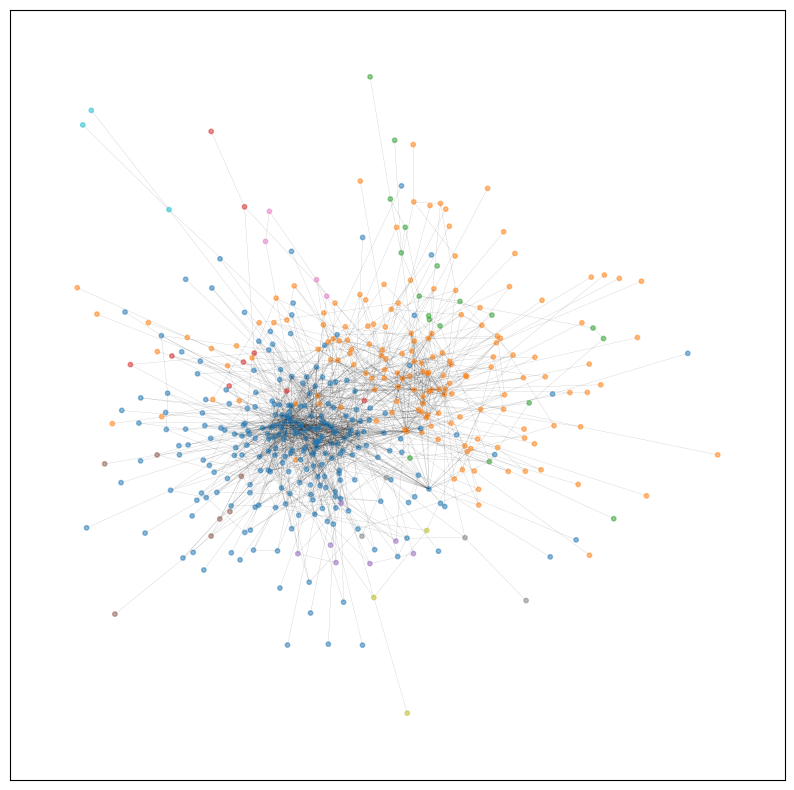

In [405]:
# resolution If resolution is less than 1, modularity favors larger communities. Greater than 1 favors smaller communities.
communities = nx.community.greedy_modularity_communities(G, resolution=0.7)

node_groups = []
for com in communities:
    node_groups.append(list(com)) 
print(len(node_groups))

palette = sns.color_palette(palette=None, n_colors=len(node_groups))

color_map = []
for node in G:
    for gr in node_groups:
        if node in gr:
            idx = node_groups.index(gr)
            color_map.append(palette[idx])
    
plt.figure(figsize=(10, 10))
nx.draw_networkx(G, pos, node_color=color_map, with_labels=False, node_size=10, width=0.1, alpha=0.5)
plt.show()

17


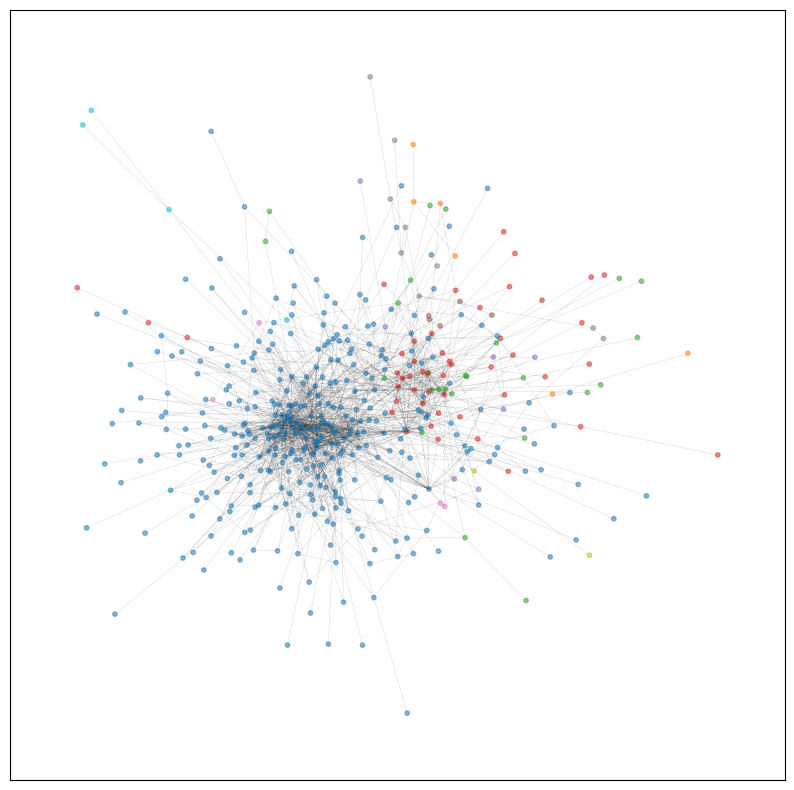

In [406]:
communities = nx.community.asyn_lpa_communities(G)

node_groups = []
for com in communities:
    node_groups.append(list(com)) 
print(len(node_groups))

palette = sns.color_palette(palette=None, n_colors=len(node_groups))

color_map = []
for node in G:
    for gr in node_groups:
        if node in gr:
            idx = node_groups.index(gr)
            color_map.append(palette[idx])
        
plt.figure(figsize=(10, 10))
nx.draw_networkx(G, pos, node_color=color_map, with_labels=False, node_size=10, width=0.1, alpha=0.5)
plt.show()

## Degree distribution

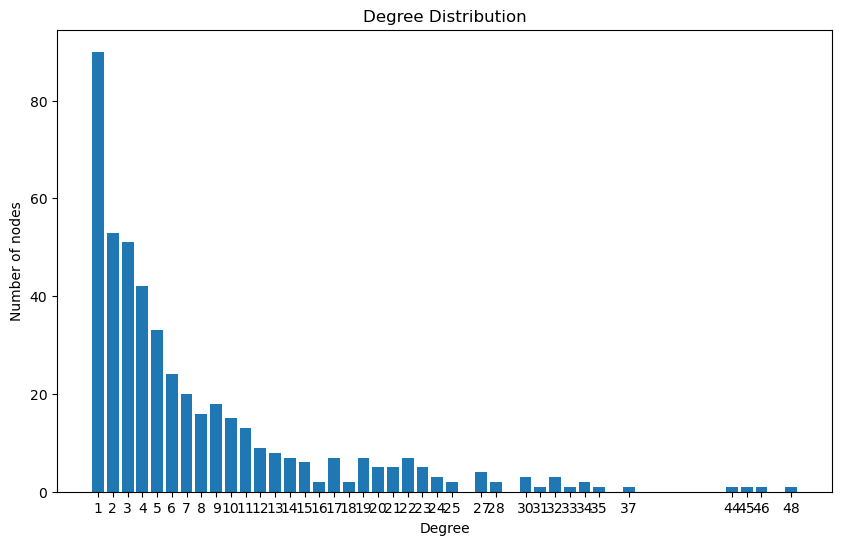

In [407]:
# Calculate degree distribution
degrees = [degree for node, degree in G.degree()]
degree_distribution = {}
for degree in degrees:
    if degree in degree_distribution:
        degree_distribution[degree] += 1
    else:
        degree_distribution[degree] = 1

# Normalize the degree distribution
# total_nodes = float(sum(degree_distribution.values()))
# for degree in degree_distribution:
#     degree_distribution[degree] /= total_nodes

# Plot the degree distribution
plt.figure(figsize=(10, 6))
plt.bar(degree_distribution.keys(), degree_distribution.values())

plt.title("Degree Distribution")
plt.ylabel("Number of nodes")
plt.xlabel("Degree")
plt.xticks(list(degree_distribution.keys()))
plt.show()

## Centrality measures

In [408]:
betweenness_centrality = list(nx.betweenness_centrality(G)) # Run betweenness centrality
eigenvector_centrality = list(nx.eigenvector_centrality(G)) # Run eigenvector centrality

In [409]:
def color_graph_by_centrality(G, pos, centrality, title):
    # Map centrality values to colors using a colormap
    # Here, we use the 'viridis' colormap, but you can choose others like 'plasma', 'inferno', etc.
    colors = plt.cm.Oranges(centrality)
    # Plot the graph
    plt.figure(figsize=(10, 10))  # Set the figure size|
    nx.draw_networkx(G, pos, node_color=centrality, cmap=plt.cm.Oranges, with_labels=False, node_size=10, width=0.1, alpha=0.5)
    # plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.Oranges), label='Eigenvector Centrality', norm=norm)
    plt.title(title)
    plt.show()

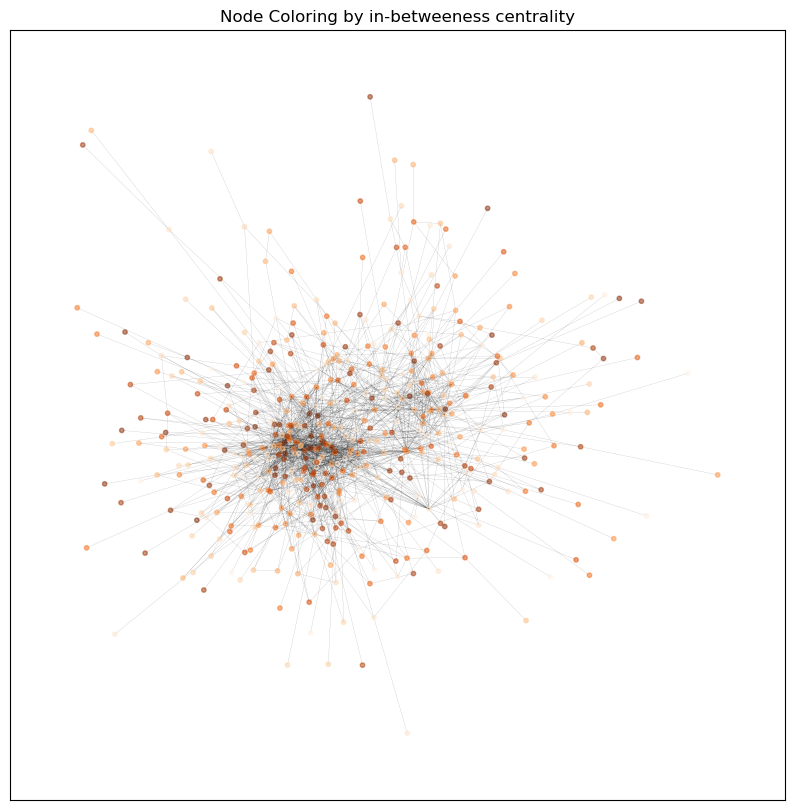

In [410]:
color_graph_by_centrality(G, pos, betweenness_centrality, 'Node Coloring by in-betweeness centrality')

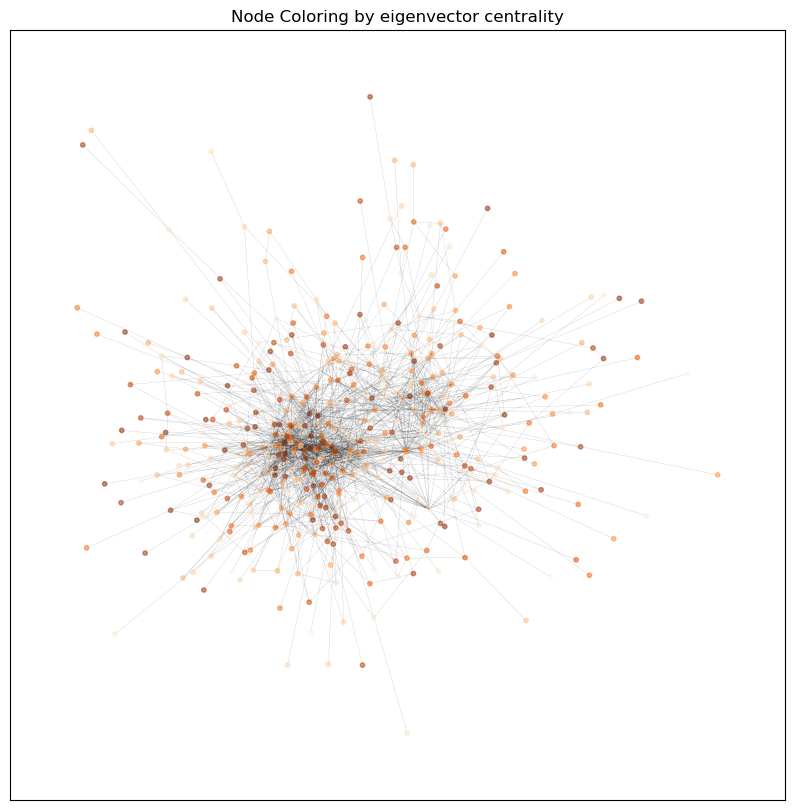

In [411]:
color_graph_by_centrality(G, pos, eigenvector_centrality, 'Node Coloring by eigenvector centrality')

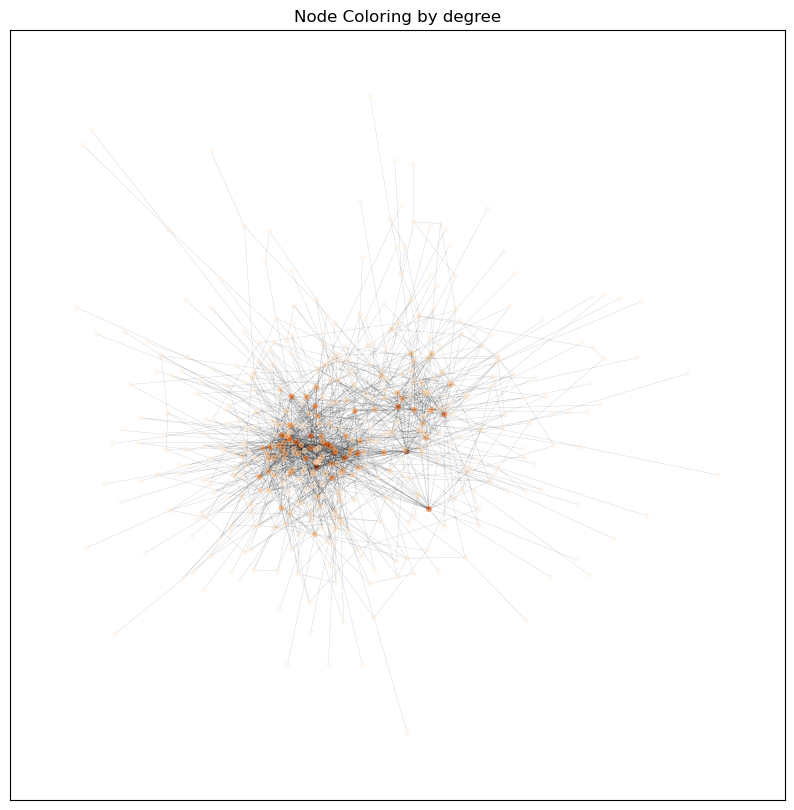

In [412]:
color_graph_by_centrality(G, pos, degrees, 'Node Coloring by degree')

In [413]:
nx.write_gexf(G, 'oo-wku-network.gexf')
nx.write_graphml(G, 'oo-wku-network.graphml')

In [414]:
user_survey = pd.read_csv(path.join(data_folder, "survey.csv")) 
question1 = "Public health officials should have the power to order people into quarantine during COVID-19 outbreaks"
question2 = "If someone is given a quarantine order by a public health official, they should follow it no matter what else is going on in their life at work or home"
question3 = "If I go into quarantine, my family, friends, and community will be protected from getting COVID-19"

In [415]:
def get_events_with_info(events, info):
    return events[events["inf"] == info]

qy_values = []
qn_values = []
qr_values = []
wm_values = []
q1_values = []
q2_values = []
q3_values = []

qy_dict = {}
qn_dict = {}
qr_dict = {}
wm_dict = {}
q1_dict = {}
q2_dict = {}
q3_dict = {}

for idx in G.nodes():
    uid = users['id'][idx]
    rid = users['random_id'][idx]
    
    user_events = events[events['user_id'] == uid]
    qy_ev = user_events[user_events['inf'] == 'quarantine']
    qn_ev = user_events[user_events['inf'] == 'noQuarantine']
    wm_ev = user_events[user_events['modifier'] == 'Wearing Mask']

    qy_num = len(qy_ev)
    qn_num = len(qn_ev)
    wm_num = len(wm_ev)

    if 0 < qy_num + qn_num:
        qr_val = qy_num / (qy_num + qn_num)
    else:    
        qr_val = np.nan
    
    q1_res = np.nan
    q2_res = np.nan
    q3_res = np.nan
    survey_responses = user_survey[user_survey['user_id'] == str(rid)]
    if len(survey_responses) == 1:
        q1_res = survey_responses['question1'].values[0]
        q2_res = survey_responses['question2'].values[0]
        q3_res = survey_responses['question3'].values[0]
        
    qy_values.append(qy_num)
    qn_values.append(qn_num)
    qr_values.append(qr_val)
    wm_values.append(wm_num)
    q1_values.append(q1_res)
    q2_values.append(q2_res)
    q3_values.append(q3_res)

    qy_dict[idx] = qy_num
    qn_dict[idx] = qn_num
    qr_dict[idx] = qr_val
    wm_dict[idx] = wm_num
    q1_dict[idx] = q1_res
    q2_dict[idx] = q2_res
    q3_dict[idx] = q3_res

user_prefs = pd.DataFrame({'quarantine_yes': qy_values, 'quarantine_no': qn_values, 'quarantine_ratio': qr_values, 'wear_mask': wm_values, 'q1_response': q1_values, 'q2_response': q2_values, 'q3_response': q3_values})

nx.set_node_attributes(G, qy_dict, 'quarantine_yes')
nx.set_node_attributes(G, qn_dict, 'quarantine_no')
nx.set_node_attributes(G, qr_dict, 'quarantine_ratio')
nx.set_node_attributes(G, wm_dict, 'wear_mask')
nx.set_node_attributes(G, q1_dict, 'q1_response')
nx.set_node_attributes(G, q2_dict, 'q2_response')
nx.set_node_attributes(G, q3_dict, 'q3_response')

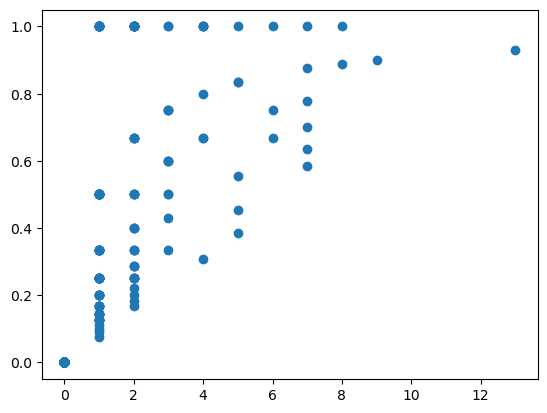

In [416]:
plt.scatter(user_prefs['quarantine_yes'], user_prefs['quarantine_ratio'])

In [417]:
corr = user_prefs.corr(method='pearson')
corr

,quarantine_yes,quarantine_no,quarantine_ratio,wear_mask,q1_response,q2_response,q3_response
quarantine_yes,1.000000,-0.135778,0.726609,0.114879,0.138604,0.103057,0.138322
quarantine_no,-0.135778,1.000000,-0.415460,0.113842,0.003093,-0.029257,0.000645
quarantine_ratio,0.726609,-0.415460,1.000000,0.011577,0.033881,0.055296,0.070513
wear_mask,0.114879,0.113842,0.011577,1.000000,0.171083,0.106659,0.030355
q1_response,0.138604,0.003093,0.033881,0.171083,1.000000,0.665693,0.536946
q2_response,0.103057,-0.029257,0.055296,0.106659,0.665693,1.000000,0.515001
q3_response,0.138322,0.000645,0.070513,0.030355,0.536946,0.515001,1.000000


In [418]:
print(nx.numeric_assortativity_coefficient(G, 'quarantine_ratio'))

nan


In [419]:
def get_attrib_data(G, attrib_name):
    data = []
    for n, m, d in G.edges(data=True):
        rn = G.nodes[n][attrib_name]
        rm = G.nodes[m][attrib_name]
        w = d['weight']
        if not np.isnan(rn) and not np.isnan(rm):
            data.append([rn, rm, w])
    return np.array(data)

def calc_weighted_assortativity(data, calc_pval=False, n_boot=100):
    W = np.sum(data[:,2])
    
    Xbar = 0
    Ybar = 0
    Xsig = 0
    Ysig = 0
    for row in range(data.shape[0]):
        Xbar += data[row,0]*data[row,2]/W
        Ybar += data[row,1]*data[row,2]/W
    for row in range(data.shape[0]):
        Xsig += data[row,2]*(data[row,0]-Xbar)**2/W
        Ysig += data[row,2]*(data[row,1]-Ybar)**2/W
    Xsig = np.sqrt(Xsig)
    Ysig = np.sqrt(Ysig)

    rho = 0
    for row in range(data.shape[0]):
        rho +=data[row,2]*(data[row,0]-Xbar)*(data[row,1]-Ybar)
        rho /= W*Xsig*Ysig

    if calc_pval:
        p_value = 0.0
        Xbar_boot = np.mean(data[:,0])
        Xsig_boot = np.std(data[:,0])
        for bootstrap in range(n_boot):
            rho_boot = 0
            for row in range(data.shape[0]):
                x = np.random.choice(data[:,0])
                y = np.random.choice(data[:,1])
                w = np.random.choice(data[:,2])
                rho_boot += w*(x-Xbar_boot)*(y-Xbar_boot)
                rho_boot /= W*Xsig_boot**2
            if rho_boot >= rho:
                p_value += 1
                # print(p_value/(bootstrap+1))
        p_value /= n_boot
        return rho, p_value
    
    return rho, None    

In [420]:
data = get_attrib_data(G, 'quarantine_ratio')

In [421]:
from statsmodels.stats.weightstats import DescrStatsW
wdata = DescrStatsW(data[:,0:2], weights=data[:,2])
wdata.corrcoef

array([[1.        , 0.15343793],
       [0.15343793, 1.        ]])

In [422]:
rho = wdata.corrcoef[0, 1]
p_value = 0.0
n_boot = 10000
for bootstrap in range(n_boot):
    rho_boot = 0
    xy = np.random.choice(data[:,0:2].flatten(), size=(data.shape[0], 2))
    ww = np.random.choice(data[:,2], size=data.shape[0])
    wdata = DescrStatsW(xy, weights=ww)
    rho_boot = wdata.corrcoef[0, 1]
    if rho_boot >= rho:
        p_value += 1
        # print(p_value/(bootstrap+1))
p_value /= n_boot
print(p_value)

0.1152
